In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.spatial import KDTree
from matplotlib import pyplot as plt

## Src imports

In [8]:
import src.config as cf
import src.data_loader as dl
import src.track_features as tf
import src.visualisation as vs
import src.track_moments as tm
import src.geometry_utils as gu
import run_pipeline as rp
from importlib import reload

reload(cf)
reload(dl)
reload(tf)
reload(vs)
reload(rp)
reload(tm)
reload(gu)

from run_pipeline import build_dataset
from src.track_features import car_from_ref_line
from src.visualisation import plot_k_turns, plot_laps, plot_lap
from src.geometry_utils import interpolate_at_distance
from src.track_moments import moment_generator, get_throttle_points, get_braking_points, get_apex_points, get_steering_points

In [158]:
df = build_dataset()


  STARTING DATA PIPELINE

[1/7] Loading data...
    Loaded 6,525,414 race records
    Loaded track data (boundaries, reference line, turns)

[2/7] Cleaning data...
    Removed 910,521 records with missing/invalid data
    Remaining: 5,614,893 records

[3/7] Filtering by distance and creating laps...
    Filtered 4,368,173 records outside distance range
    Created lap IDs for 1,051 unique laps
Removing laps: 
    995 - 1 data-point(s)
    431 - 30 data-point(s)
    726 - 40 data-point(s)
    40 - 57 data-point(s)
    603 - 315 data-point(s)
    434 - 373 data-point(s)
    267 - 475 data-point(s)
    97 - 509 data-point(s)
    418 - 737 data-point(s)
    602 - 869 data-point(s)
    922 - 869 data-point(s)
Removed 4275 rows
    Remaining: 1,242,445 records after low-info lap removal

[4/7] Computing track features...


Calculating right edge widths: 100%|██████████| 5766/5766 [00:00<00:00, 18976.03it/s]


    Calculated track width at all points


Processing car positions: 100%|██████████| 1242445/1242445 [03:55<00:00, 5273.41it/s]


    Computed distances to track edges


Referencing relative ref line: 100%|██████████| 1242445/1242445 [00:53<00:00, 23219.86it/s]


    Computed distances from reference line

[5/7] Computing apex features...
    Calculated distances to apex points
    Calculated angles to apex points

[6/7] Identifying off-track incidents...
    Valid laps: 400
    Invalid laps (off-track): 640

[7/7] Saving processed data...
    Saved to: data\processed_race_data.csv
    Dataset shape: 1,242,445 rows × 51 columns

  STAGE 1 COMPLETE: PROCESSED DATA READY

  STAGE 2: CREATING FINAL FEATURE DATASET

Extracting track moments...


Computing moment points: 100%|█| 4/4 [00:09<00:00,  2.31s/it, Steering



 Generating braking moments...


Braking features: 100%|█████████████████| 2/2 [00:05<00:00,  2.60s/it]


Generating throttle moments...


Throttle features: 100%|████████████████| 2/2 [00:05<00:00,  2.66s/it]


Generating steering moments...


Steering features: 100%|████████████████| 3/3 [00:13<00:00,  4.42s/it]


Generating apex moments...


Apex features: 100%|████████████████████| 2/2 [00:05<00:00,  2.63s/it]


Generating distance-based moments...


Distance features: 100%|████████████████| 3/3 [00:08<00:00,  2.82s/it]


Generating target variable...

Combining all features...

Saving final dataset...
    Saved to: data\final_data_product.csv
    Final shape: 1,040 rows × 278 columns
    Features: 278 total columns

  PIPELINE COMPLETE! 🎉

 Summary:
   • Total laps: 1,040
   • Total features: 278
   • Output file: data\final_data_product.csv


In [3]:
df = pd.read_csv("data/processed_race_data.csv")


In [9]:
am = build_dataset(df, start_stage=2)


  STARTING DATA PIPELINE

  STAGE 1 COMPLETE: PROCESSED DATA READY

  STAGE 2: CREATING FINAL FEATURE DATASET

Extracting track moments...


Computing moment points: 100%|█| 4/4 [00:10<00:00,  2.69s/it, Steering



 Generating braking moments...


Braking features: 100%|█████████████████| 2/2 [00:10<00:00,  5.18s/it]


Generating throttle moments...


Throttle features: 100%|████████████████| 2/2 [00:09<00:00,  4.80s/it]


Generating steering moments...


Steering features: 100%|████████████████| 3/3 [00:22<00:00,  7.35s/it]


Generating apex moments...


Apex features: 100%|████████████████████| 2/2 [00:08<00:00,  4.28s/it]


Generating distance-based moments...


Distance features: 100%|████████████████| 3/3 [00:11<00:00,  3.75s/it]


Generating target variable...

Combining all features...

Saving final dataset...
    Saved to: data\final_data_product.csv
    Final shape: 1,040 rows × 255 columns
    Features: 255 total columns

  PIPELINE COMPLETE! 🎉

 Summary:
   • Total laps: 1,040
   • Total features: 255
   • Output file: data\final_data_product.csv


In [16]:
am.iloc[am.BPS_CURRENTLAPTIMEINMS.argmin()]

lap_id                      99.000000
invalid_lap                  1.000000
BPS_SPEED                  280.000000
BPS_THROTTLE                 0.659744
BPS_STEER                    0.000000
                              ...    
dist_530_dist_apex_1       132.522665
dist_530_dist_apex_2        33.560291
dist_530_angle_to_apex1    129.779493
dist_530_angle_to_apex2    150.156732
dist_530_proj_from_ref       3.409902
Name: 97, Length: 255, dtype: float64

In [30]:
am[am["invalid_lap"] == 0].sort_values(by="Target_CURRENTLAPTIMEINMS", ascending=True)

lap_id  invalid_lap  BPS_SPEED  BPS_THROTTLE  BPS_STEER  BPS_BRAKE  \
851      860            0      324.0      1.000000   0.002488        0.0   
587      593            0      322.0      0.025177   0.006011        0.0   
18        18            0      324.0      1.000000  -0.001986        0.0   
72        73            0      324.0      1.000000  -0.001523        0.0   
907      916            0      324.0      1.000000  -0.007860        0.0   
...      ...          ...        ...           ...        ...        ...   
396      399            0      175.0      0.075392   0.185236        0.0   
757      766            0      293.0      1.000000   0.000748        0.0   
405      408            0        NaN           NaN        NaN        NaN   
776      785            0      144.0      0.008744   0.023022        0.0   
1023    1034            0      248.0      0.627795   0.025647        0.0   

      BPS_CURRENTLAPTIMEINMS  BPS_LAPDISTANCE  BPS_WORLDPOSITIONX  \
851                   2980.0            262.0          301.815228   
587                   3049.0            269.0          307.165908   
18                    2965.0            261.0          288.263085   
72                    2866.0            253.0          285.162681   
907                   3115.0            274.0          310.731233   
...                      ...              ...                 ...   
396                   7461.0            359.0          358.414833   
757                   2767.0            212.0          260.868649   
405                      NaN              NaN                 NaN   
776                   7961.0            309.0          328.229727   
1023                  3992.0            267.0          240.243964   

      BPS_WORLDPOSITIONY  ...  dist_530_YAW  dist_530_PITCH  dist_530_ROLL  \
851           286.106392  ...     -2.641409       -0.001524      -0.009476   
587           281.569461  ...     -2.683784       -0.003549      -0.013458   
18            299.421895  ...     -2.716097       -0.003371      -0.011621   
72            301.957637  ...     -2.679794       -0.002610      -0.008511   
907           278.061578  ...     -2.684987       -0.003394      -0.012071   
...                  ...  ...           ...             ...            ...   
396           226.640659  ...     -2.678528        0.002175      -0.022795   
757           321.383580  ...     -2.702998        0.002257      -0.028142   
405                  NaN  ...     -2.671238        0.004404      -0.027408   
776           257.298551  ...     -2.669456        0.003789      -0.022580   
1023          337.496224  ...     -2.226204        0.011175       0.025393   

      dist_530_left_dist  dist_530_right_dist  dist_530_dist_apex_1  \
851             3.138879             9.453740            133.318410   
587             4.000375             8.592165            133.726732   
18              3.151400             9.470035            132.455785   
72              3.248921             9.343625            133.371880   
907             3.811105             8.781417            133.637519   
...                  ...                  ...                   ...   
396             3.971504             8.621030            133.713193   
757             5.048653             7.631510            128.036324   
405             4.002000             8.590542            133.727455   
776             4.681158             7.938543            133.175932   
1023            7.328570             6.396926            199.053977   

      dist_530_dist_apex_2  dist_530_angle_to_apex1  dist_530_angle_to_apex2  \
851              33.812458              -177.619831              -159.466116   
587              33.972230              -177.665140              -160.617290   
18               32.852676              -177.530768              -159.457203   
72               33.833407              -177.510166              -159.498217   
907              33.936273              -177.616269              -160.3263

In [41]:
new_moments = []
for m in am:
    if "lap_id" not in m:
        new_moments.append(m.reset_index())
    else:
        new_moments.append(m)

In [48]:
total = am[0]
for m in new_moments[1:]:
    total = total.merge(m, how='outer', on="lap_id")

In [ ]:
total[total["invalid_lap"] == 0].sort_values(by="Target_CURRENTLAPTIMEINMS", ascending=True)

lap_id  invalid_lap  BPS_SPEED  BPS_THROTTLE  BPS_STEER  BPS_BRAKE  \
851      860            0      322.0      1.000000   0.000991   0.000000   
587      593            0      322.0      1.000000  -0.003065   0.000000   
18        18            0      324.0      1.000000  -0.001986   0.000000   
72        73            0      322.0      0.753884  -0.001656   0.167300   
907      916            0        NaN           NaN        NaN        NaN   
...      ...          ...        ...           ...        ...        ...   
396      399            0      174.0      0.165468   0.006036   0.000247   
757      766            0        NaN           NaN        NaN        NaN   
405      408            0        NaN           NaN        NaN        NaN   
776      785            0      146.0      0.205389  -0.008317   0.000000   
1023    1034            0      248.0      0.628611   0.015784   0.000000   

      BPS_CURRENTLAPTIMEINMS  BPS_LAPDISTANCE  BPS_WORLDPOSITIONX  \
851                   2613.0            229.0          277.979380   
587                   2582.0            227.0          276.481104   
18                    2965.0            261.0          288.263085   
72                    3022.0            267.0          305.526617   
907                      NaN              NaN                 NaN   
...                      ...              ...                 ...   
396                   5122.0            245.0          284.048995   
757                      NaN              NaN                 NaN   
405                   3596.0            199.0          253.263628   
776                   7025.0            271.0          306.250349   
1023                  3746.0            250.0          240.243964   

      BPS_WORLDPOSITIONY  ...  dist_530_ROLL  dist_530_left_dist  \
851           308.888745  ...      -0.009476            3.138879   
587           310.208926  ...      -0.013458            4.000375   
18            299.421895  ...      -0.011621            3.151400   
72            282.751783  ...      -0.008511            3.248921   
907                  NaN  ...      -0.012071            3.811105   
...                  ...  ...            ...                 ...   
396           300.802602  ...      -0.022795            3.971504   
757                  NaN  ...      -0.028142            5.048653   
405           326.483515  ...      -0.027408            4.002000   
776           277.732007  ...      -0.022580            4.681158   
1023          337.496224  ...       0.025393            7.328570   

      dist_530_right_dist  dist_530_l_width  dist_530_r_width  \
851              9.453740         12.585486         12.594840   
587              8.592165         12.585486         12.594840   
18               9.470035         12.613132         12.619692   
72               9.343625         12.585486         12.594840   
907              8.781417         12.585486         12.594840   
...                   ...               ...               ...   
396              8.621030         12.585486         12.594840   
757              7.631510         12.677882         12.682140   
405              8.590542         12.585486         12.594840   
776              7.938543         12.613132         12.619692   
1023             6.396926         13.728886         13.722800   

      dist_530_dist_apex_1  dist_530_dist_apex_2  dist_530_angle_to_apex1  \
851             133.318410             33.812458              -177.619831   
587             133.726732             33.972230              -177.665140   
18              132.455785             32.852676              -177.530768   
72              133.371880             33.833407              -177.510166   
907             133.637519             33.936273              -177.616269   
...                    ...                   ...                      ...   
396             133.713193             33.966771              -178.395009   
757             128.036324             27.394519  

In [39]:
# cleanned_data = pd.read_csv("data/cleanned_data.csv")
DATAFOLDER = "data"
track_left = pd.read_csv(f"{DATAFOLDER}/f1sim-ref-left.csv")
track_right = pd.read_csv(f"{DATAFOLDER}/f1sim-ref-right.csv")
track_line = pd.read_csv(f"{DATAFOLDER}/f1sim-ref-line.csv")
turns = pd.read_csv(f"{DATAFOLDER}/f1sim-ref-turns.csv")

In [103]:
output = build_dataset(cleanned_data, start_stage = 1)


Starting Data Pipeline

Final dataset shape: (1242445, 52)
Columns: ['Unnamed: 0', 'SESSION_GUID', 'CURRENTLAPNUM', 'SESSIONUID', 'SPEED', 'THROTTLE', 'STEER', 'BRAKE', 'GEAR', 'ENGINERP1', 'DRS', 'BRAKESTEMPERATURE_RL', 'BRAKESTEMPERATURE_RR', 'BRAKESTEMPERATURE_FL', 'BRAKESTEMPERATURE_FR', 'TYRESPRESSURE_RL', 'TYRESPRESSURE_RR', 'TYRESPRESSURE_FL', 'TYRESPRESSURE_FR', 'CURRENTLAPTIMEINMS', 'LAPDISTANCE', 'TOTALDISTANCE', 'CURRENTLAPNU1', 'CURRENTLAPINVALID', 'WORLDPOSITIONX', 'WORLDPOSITIONY', 'WORLDPOSITIONZ', 'WORLDFORWARDDIRX', 'WORLDFORWARDDIRY', 'WORLDFORWARDDIRZ', 'WORLDRIGHTDIRX', 'WORLDRIGHTDIRY', 'WORLDRIGHTDIRZ', 'YAW', 'PITCH', 'ROLL', 'FRONTWHEELSANGLE', 'TRACKID', 'R_STATUS', 'LAPTIME', 'CURRENTLAPTIME', 'lap_id', 'left_dist', 'right_dist', 'l_width', 'r_width', 'proj_from_ref', 'dist_apex_1', 'dist_apex_2', 'angle_to_apex1', 'angle_to_apex2', 'invalid_lap']

Stage 1 (processed data) Complete!
Creating Final Product


KeyboardInterrupt: 

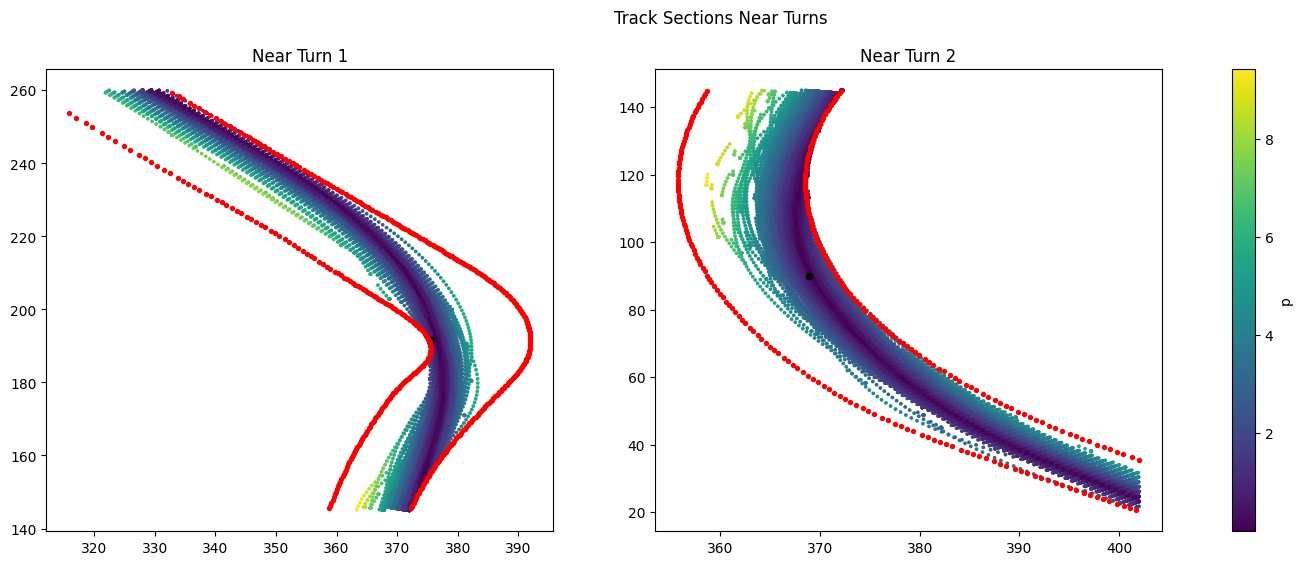

In [5]:
plot_k_turns(cleanned_data[cleanned_data["invalid_lap"] == 0], turns, track_left, track_right,x_col="WORLDPOSITIONX", y_col="WORLDPOSITIONY", color_col="proj_from_ref", k = 2)

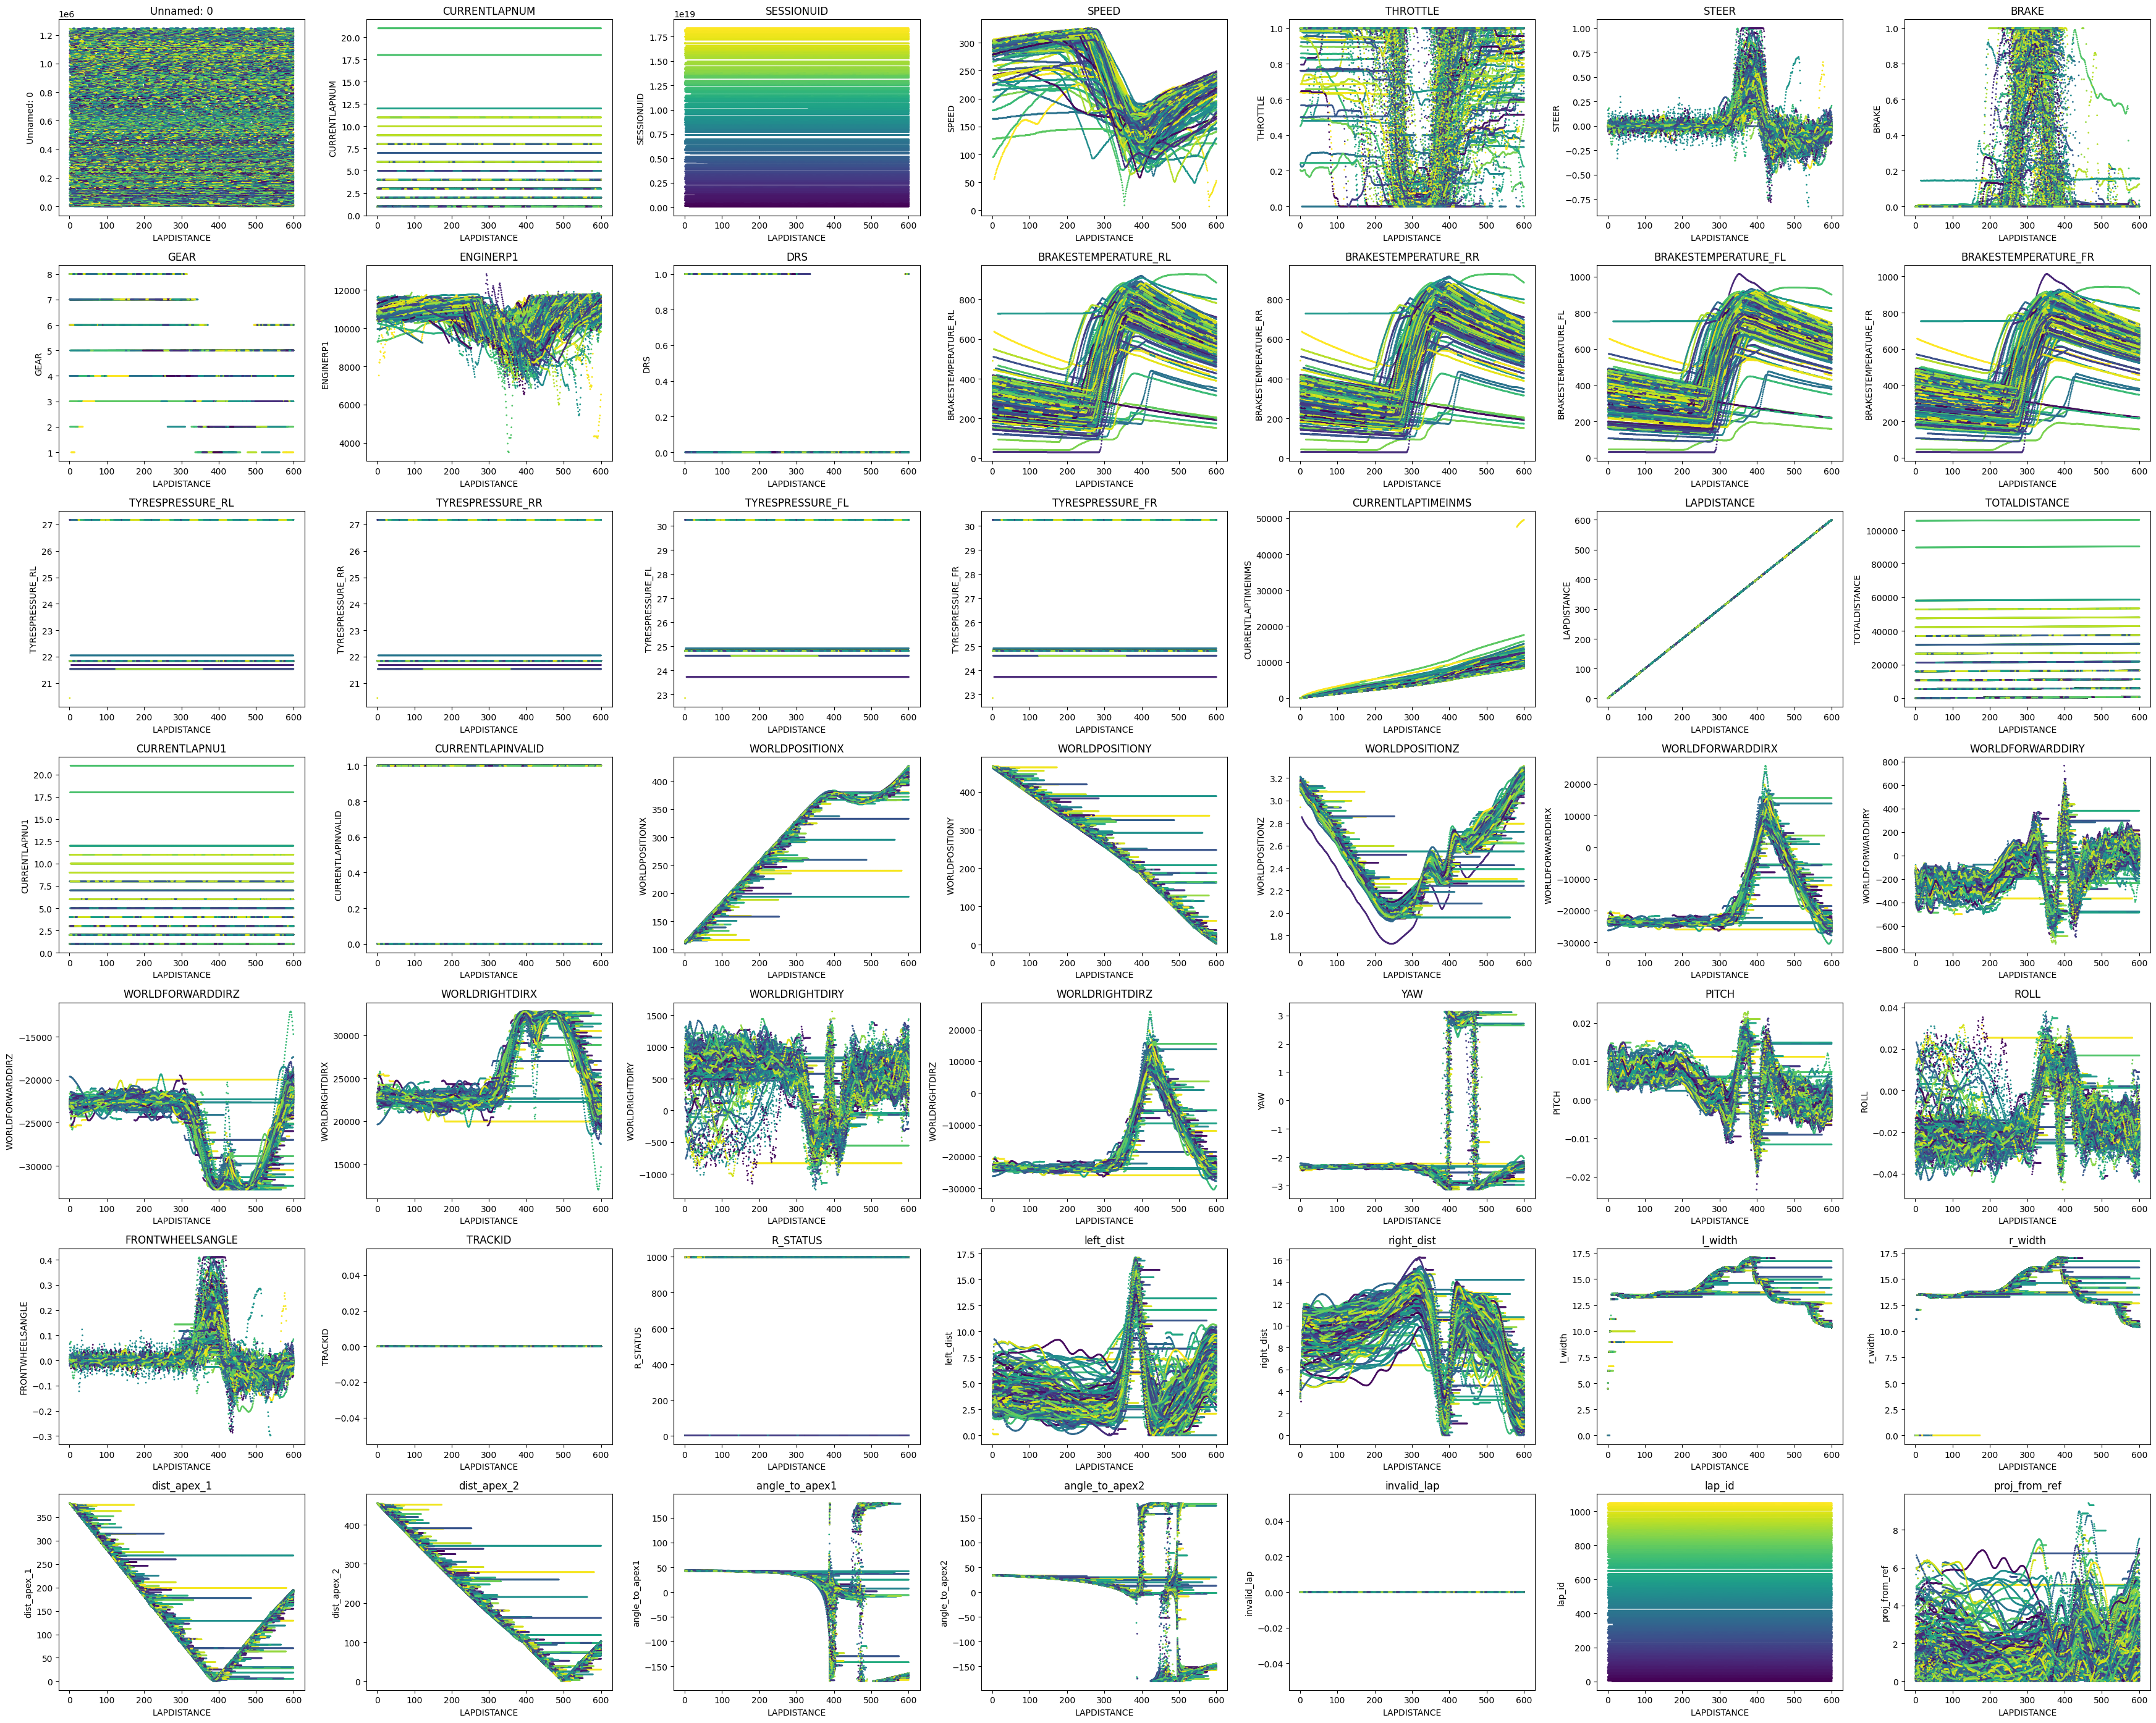

In [ ]:
import math

# select numeric columns only
num_cols = [col for col in cleanned_data.columns if cleanned_data[col].dtype != "object"]

n = len(num_cols)
ncols = 7  # you can change grid width
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

axes = axes.flatten()  # make iterable

for i, col in enumerate(num_cols):
    ax = axes[i]
    plot_laps(cleanned_data, y_col=col, distance_range=(0, 600), ax=ax)
    ax.set_title(col)

# turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


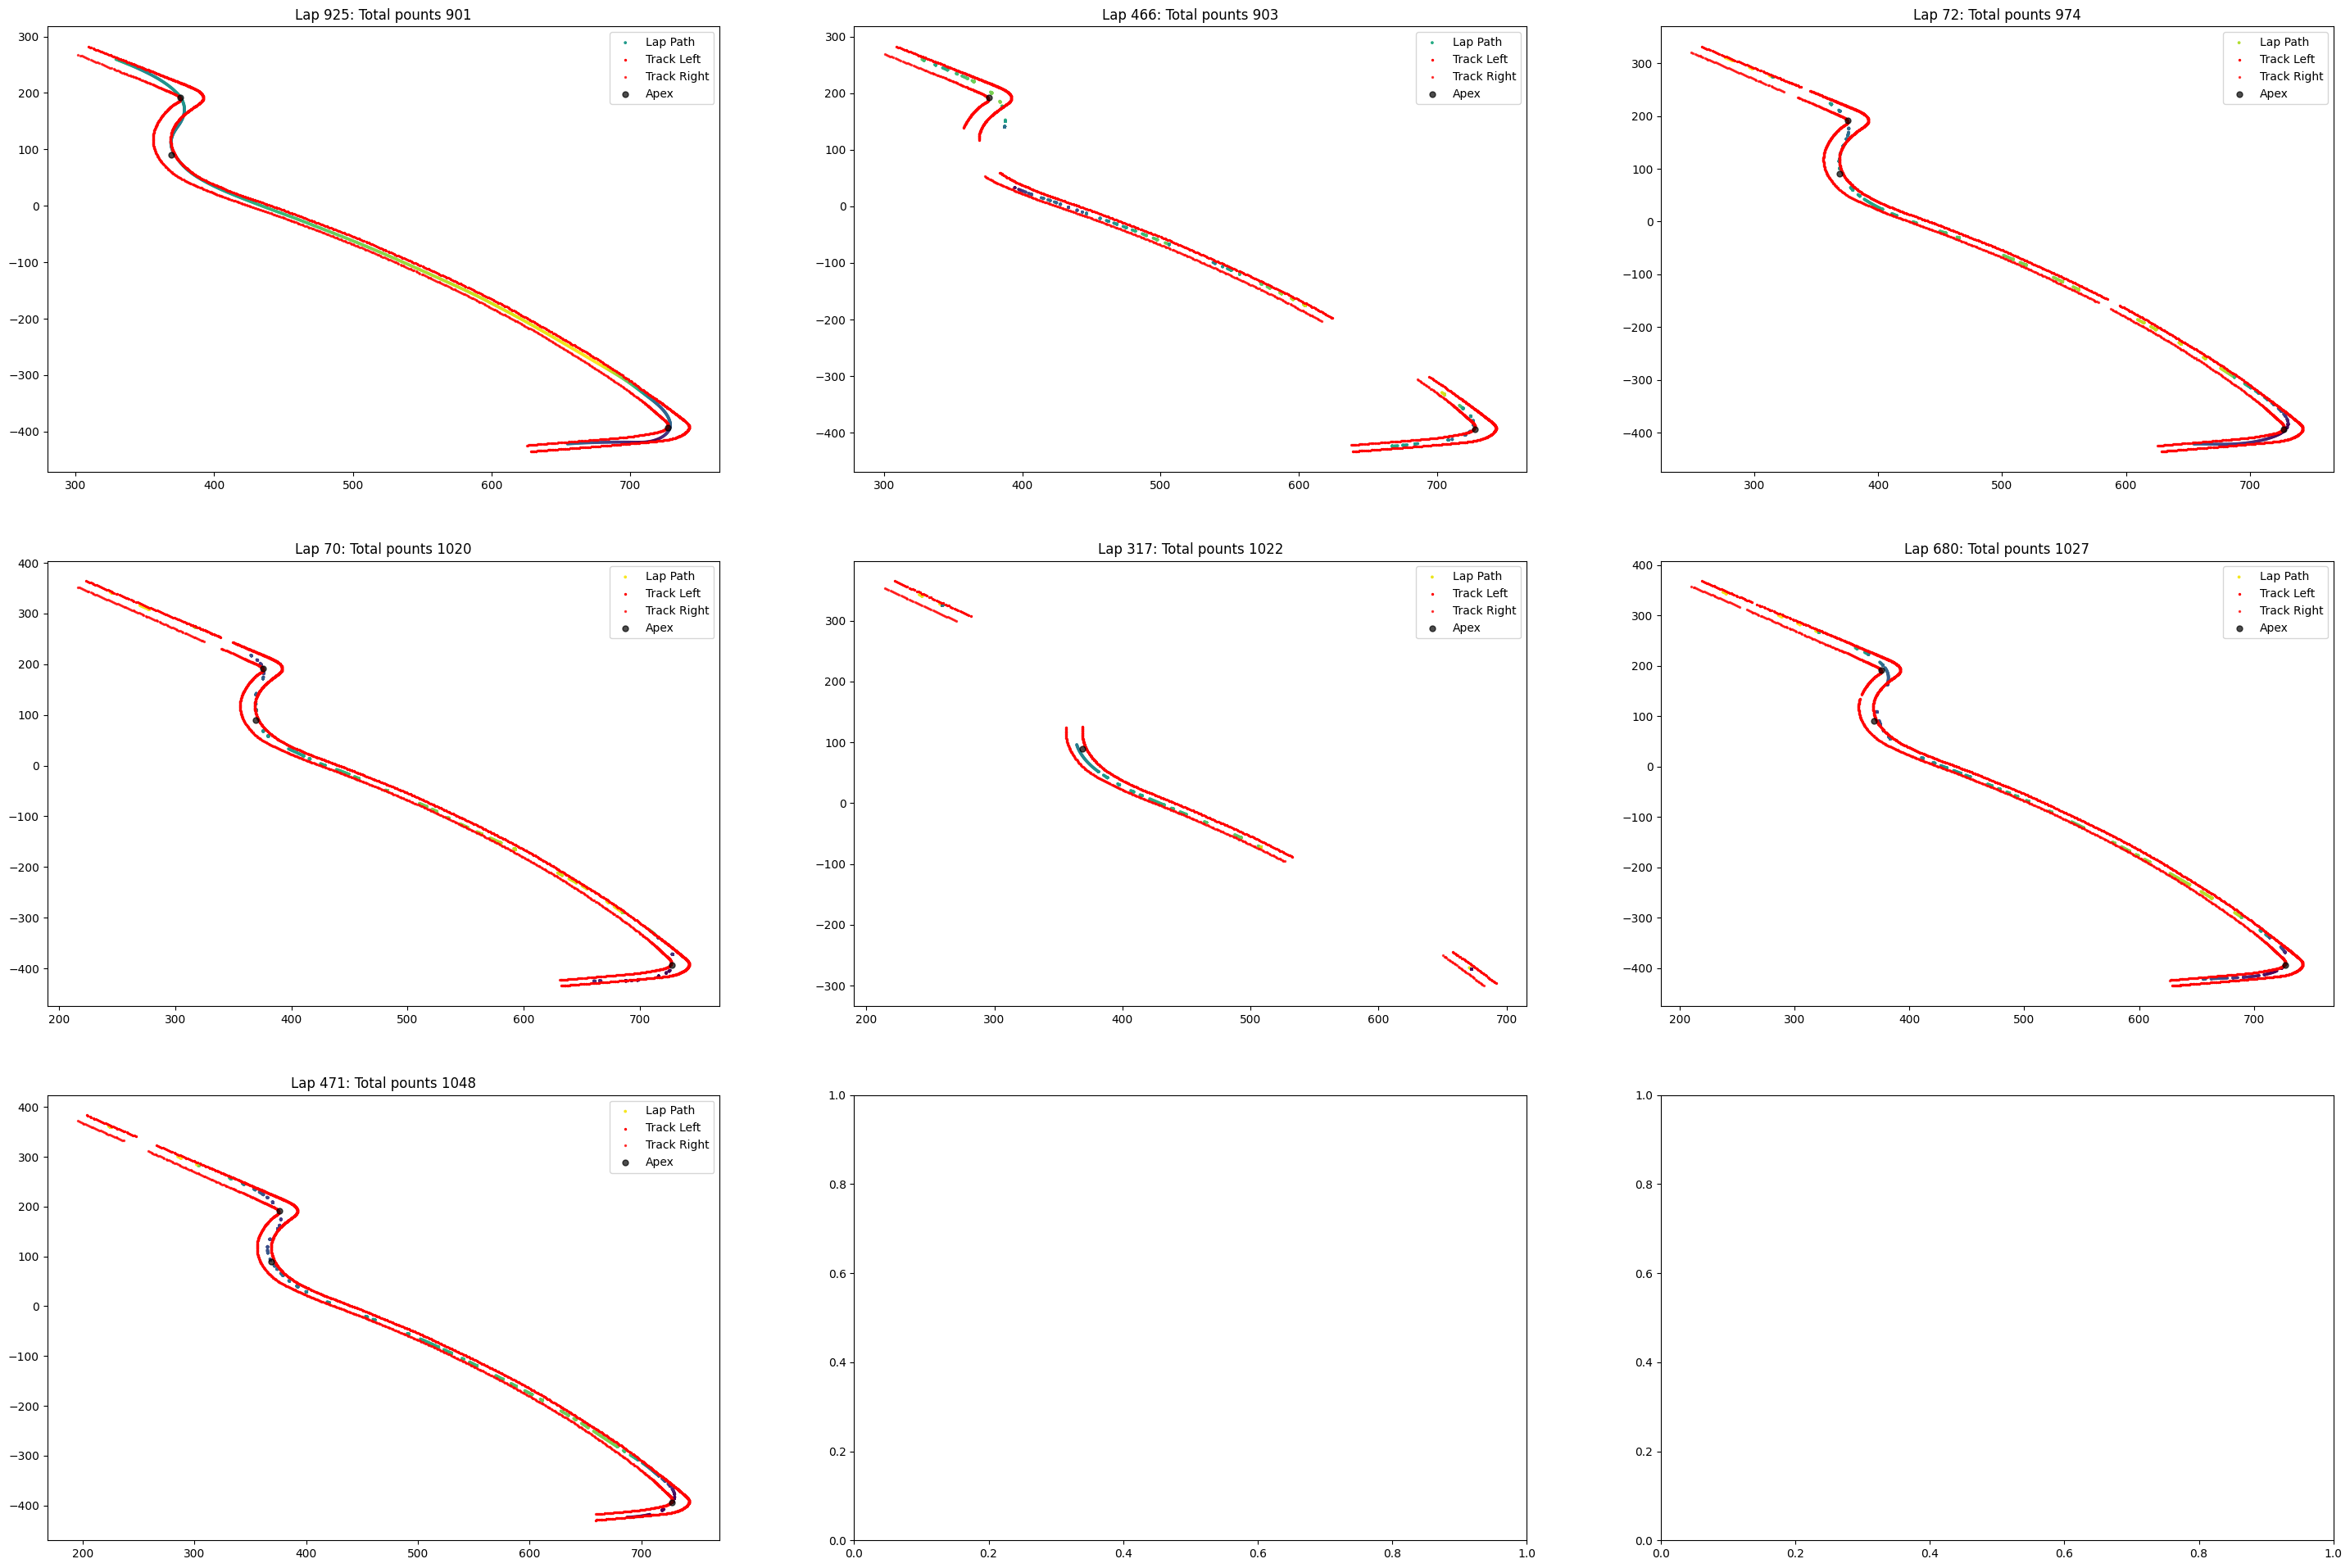

In [ ]:
datapoints = cleanned_data.groupby("lap_id").size()
datapoints = datapoints[datapoints < 1050].sort_values()

ncols = 3
nrows = (len(datapoints) // ncols) + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(12*ncols, 8*nrows))

axes = axes.flatten()  # make iterable

for (lap_id, amount), ax in zip(datapoints.items(), axes):
    plot_lap(cleanned_data[cleanned_data["lap_id"] == lap_id], track_left, track_right, turns, color_col="SPEED", ax=ax)
    ax.set_title(f"Lap {lap_id}: Total pounts {amount}")

In [19]:
df

SESSION_GUID  CURRENTLAPNUM           SESSIONUID  \
0        1BF21BECE1C29DBFE0631718000AACA5              1  3884830849894045108   
1        1BF21BECE1C29DBFE0631718000AACA5              1  3884830849894045108   
2        1BF21BECE1C29DBFE0631718000AACA5              1  3884830849894045108   
3        1BF21BECE1C29DBFE0631718000AACA5              1  3884830849894045108   
4        1BF21BECE1C29DBFE0631718000AACA5              1  3884830849894045108   
...                                   ...            ...                  ...   
1242440  31D5ED912780726FE0631818000AEAF9              2  6494192071428401353   
1242441  31D5ED912780726FE0631818000AEAF9              2  6494192071428401353   
1242442  31D5ED912780726FE0631818000AEAF9              2  6494192071428401353   
1242443  31D5ED912780726FE0631818000AEAF9              2  6494192071428401353   
1242444  31D5ED912780726FE0631818000AEAF9              2  6494192071428401353   

         SPEED  THROTTLE     STEER  BRAKE  GEAR  ENGINERP1  DRS  ...  \
0        299.0       1.0  0.000000    0.0   8.0    10656.0  0.0  ...   
1        299.0       1.0  0.000000    0.0   8.0    10658.0  0.0  ...   
2        299.0       1.0  0.000000    0.0   8.0    10659.0  0.0  ...   
3        299.0       1.0  0.000000    0.0   8.0    10660.0  0.0  ...   
4        299.0       1.0  0.000000    0.0   8.0    10662.0  0.0  ...   
...        ...       ...       ...    ...   ...        ...  ...  ...   
1242440  141.0       1.0  0.023598    0.0   3.0    10847.0  0.0  ...   
1242441  142.0       1.0  0.017215    0.0   3.0    10918.0  0.0  ...   
1242442  143.0       1.0  0.012374    0.0   3.0    10980.0  0.0  ...   
1242443  145.0       1.0  0.010213    0.0   3.0    11025.0  0.0  ...   
1242444  146.0       1.0  0.006747    0.0   3.0    11089.0  0.0  ...   

         left_dist  right_dist    l_width    r_width  proj_from_ref  \
0         2.119045   11.141234  13.261554  13.260272       0.066355   
1         2.119052   11.144147  13.261554  13.260272       0.065386   
2         2.118991   11.147151  13.267978  13.267137       0.064672   
3         2.119299   11.150750  13.273649  13.267137       0.064618   
4         2.119722   11.154651  13.273649  13.274641       0.064967   
...            ...         ...        ...        ...            ...   
1242440   4.564211    7.038152  11.602141  11.603249       0.449584   
1242441   4.716310    6.890654  11.606784  11.606188       0.500928   
1242442   4.870143    6.741881  11.611959  11.613600       0.549587   
1242443   5.026950    6.589380  11.617830  11.616311       0.591819   
1242444   5.184776    6.435370  11.621561  11.619069       0.628689   

         dist_apex_1  dist_apex_2  angle_to_apex1  angle_to_apex2  invalid_lap  
0         299.116905   376.259397       42.563474       31.217106            0  
1         298.119090   375.291679       42.560506       31.186441            0  
2         297.121262   374.324121       42.574453       31.172564            0  
3         296.123444   373.356729       42.585913       31.156073            0  
4         295.125635   372.389507       42.599718       31.141799            0  
...              ...          ...             ...             ...          ...  
1242440   683.341057   597.439877       26.890968       31.780343            0  
1242441   682.935434   596.956798       26.743152       31.624978            0  
1242442   682.528982   596.473020       26.598845       31.473103            0  
1242443   682.120159   595.987048       26.463302       31.329987            0  
1242444   681.711092   595.500932       26.350460       31.209544            0  

[1242445 rows x 51 columns]

In [23]:
dist_df = df[["lap_id"]].drop_duplicates().sort_values("lap_id").copy()
dist_df["dist"] = 900
dist_df

lap_id  dist
536448        0   900
886009        1   900
823407        2   900
1089745       3   900
35087         4   900
...         ...   ...
812119     1046   900
595132     1047   900
1003092    1048   900
264601     1049   900
390009     1050   900

[1040 rows x 2 columns]

In [24]:
target_df = moment_generator(
        df, "Target", ["CURRENTLAPTIMEINMS"], dist_df[["lap_id", "dist"]])

In [29]:
target_df.sort_values("Target_CURRENTLAPTIMEINMS", ascending=True).head(20)

Target_CURRENTLAPTIMEINMS
lap_id                           
819                             0
14                              0
734                             0
821                             0
816                             0
836                             0
92                              0
479                             0
634                         12096
591                         12146
108                         12192
860                         12204
590                         12214
892                         12217
593                         12219
592                         12220
18                          12242
73                          12245
916                         12250
67                          12255

cleanned_data

In [33]:
bps = get_braking_points(df)
thp = get_throttle_points(df)
sta = get_steering_points(df)

In [ ]:

		
BP_moment_data = moment_generator(cleanned_data, "BPS", features, bps["BP_LD"], bps["max_brake_LD"])
BP_moment_data = moment_generator(cleanned_data, "THS", features, thp["first_lift_LD"], thp["min_throttle_LD"])
BP_moment_data = moment_generator(cleanned_data, "THE", features, thp["back_on_LD"], thp["back_on_max_LD"])

BP_moment_data

BP_SPEED  BP_THROTTLE  BP_STEER  BP_BRAKE  BP_CURRENTLAPTIMEINMS  \
lap_id                                                                     
0          288.0     0.000000  0.012484  0.000000                   3806   
1          310.0     0.039252  0.004378  0.000000                   2076   
2          310.0     0.977729  0.013128  0.000000                   3413   
3          308.0     0.000000  0.023153  0.000000                   3074   
4          265.0     0.000902 -0.019868  0.000000                   3765   
...          ...          ...       ...       ...                    ...   
1035       324.0     1.000000  0.000600  0.000000                   2632   
1036       223.0     0.038591  0.009433  0.018612                   3824   
1037       214.0     0.000000 -0.010614  1.000000                   3845   
1038       288.0     0.374097  0.013650  0.015583                   2738   
1039       277.0     0.001393  0.004246  0.044985                   3160   

        BP_LAPDISTANCE  BP_WORLDPOSITIONX  BP_WORLDPOSITIONY  \
lap_id                                                         
0                  325         344.540329         245.387874   
1                  177         238.719781         343.043929   
2                  283         316.145481         270.704681   
3                  258         298.354565         288.281977   
4                  272         309.161183         279.315128   
...                ...                ...                ...   
1035               232         275.053447         311.605407   
1036               301         324.537627         264.996802   
1037               324         334.390771         255.038967   
1038               225         265.213756         320.104951   
1039               265         292.313849         293.544075   

        BP_WORLDFORWARDDIRX  BP_WORLDFORWARDDIRY  ...  BP_right_dist  \
lap_id                                            ...                  
0                  -23030.0                245.0  ...      14.194831   
1                  -23808.0               -256.0  ...       9.340633   
2                  -24755.0                 55.0  ...      12.231785   
3                  -23416.0                  0.0  ...      12.011931   
4                  -23513.0                -34.0  ...      13.370009   
...                     ...                  ...  ...            ...   
1035               -23591.0                -97.0  ...      12.050645   
1036               -23608.0                -59.0  ...      14.111074   
1037               -22434.0                 79.0  ...      13.997805   
1038               -24586.0               -256.0  ...      11.225422   
1039               -24536.0               -138.0  ...      11.430757   

        BP_l_width  BP_r_width  BP_dist_apex_1  BP_dist_apex_2  \
lap_id                                                           
0        16.105150   16.114276       62.166679      157.290328   
1        13.747820   13.747473      204.175872      284.580272   
2        15.581054   15.586368       99.003260      188.256174   
3        14.815240   14.812881      123.795384      210.467657   
4        15.248776   15.236822      110.083110      198.525890   
...            ...         ...             ...             ...   
1035     13.955834   13.949319      156.602435      240.669407   
1036     15.796257   15.788893       89.461112      180.539645   
1037     16.051038   16.058871       75.700166      168.614409   
1038     13.785517   13.778336      169.448657      252.399184   
1039     14.508324   14.555931      131.684101      217.486149   

        BP_angle_to_apex1  BP_angle_to_apex2  BP_proj_from_ref  \
lap_id                                                           
0               30.552407           9.529868          0.323963   
1               41.470810          26.613183          2.120974   
2               37.013520          16.410581          1.649955   
3               38.589353          19.592408          1.1032

In [ ]:
thp

lap_id  first_lift_LD  min_throttle_LD  back_on_LD  back_on_max_LD
0          0          200.0            256.0       470.0           688.0
1          1          153.0            182.0       393.0           710.0
2          2          284.0            297.0       421.0           550.0
3          3          238.0            255.0       403.0           710.0
4          4          264.0            273.0       409.0           521.0
...      ...            ...              ...         ...             ...
1035    1046          238.0            353.0       363.0           409.0
1036    1047          302.0            382.0       385.0           524.0
1037    1048          329.0            331.0       371.0           444.0
1038    1049           71.0             97.0       117.0           126.0
1039    1050          267.0            339.0       403.0           493.0

[1040 rows x 5 columns]

<Axes: >

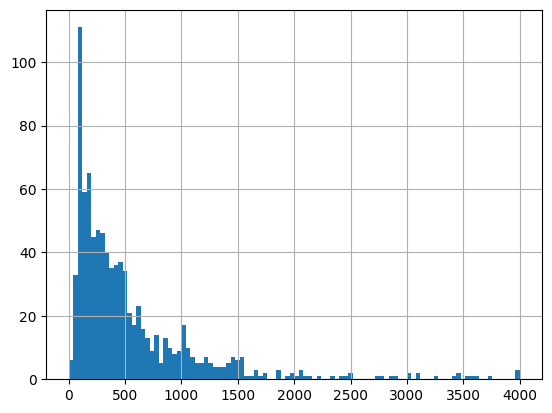

In [ ]:
BP_moment_data["BP_ext_TIMETOINMS"].clip(-1,4000).hist(bins=100)

In [ ]:

for idx in cleanned_data[cleanned_data["invalid_lap"] == 0].lap_id.sort_values().unique():
    # ax = plt.gca()
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(12*2, 8*1))

    plot_laps(cleanned_data[cleanned_data["lap_id"] == idx], y_col="THROTTLE", distance_range=(0, 600), ax=axs[0], only_valid=False)
    plot_laps(cleanned_data[cleanned_data["lap_id"] == idx], y_col="BRAKE", distance_range=(0, 600), ax=axs[1], only_valid=False)
    plot_laps(cleanned_data[cleanned_data["lap_id"] == idx], y_col="STEER", distance_range=(0, 1200), ax=axs[2], only_valid=False)

    axs[0].set_title(f"Lap_id {idx} BRAKE vs LAPDISTANCE")

    for line in ["first_lift_LD", "min_throttle_LD", "back_on_LD", "back_on_max_LD"]:
        axs[0].vlines(thp[thp["lap_id"] == idx][line], 0, 1, colors="red")
    
    for line in ["BP_LD", "max_brake_LD", "brake_decrease_LD", "brake_end_LD"]:
        axs[1].vlines(bps[bps["lap_id"] == idx][line], 0, 1)

    for line in ["first_steer_LD", "max_pos_angle_steer_LD",  "middle_TP_LD", "max_neg_LD", "end_steer_LD"]:
        axs[2].vlines(sta[sta["lap_id"] == idx][line], 0, 1)

    plt.show()

In [66]:
sta[sta["first_steer_LD"] < 200]

lap_id  first_steer_LD  max_pos_angle_steer_LD  decrease_from_max_LD  \
97       99            92.0                   129.0                 125.0   
454     460            42.0                    96.0                  91.0   
725     734           189.0                   198.0                 199.0   
744     753            29.0                    49.0                  43.0   
805     814            27.0                    70.0                  71.0   
807     816           123.0                   134.0                 135.0   
812     821           131.0                   159.0                 160.0   
833     842           194.0                   203.0                 198.0   

     middle_TP_LD  max_neg_LD  increase_from_min_LD  end_steer_LD  
97     128.302426       696.0                 692.0    705.227505  
454    128.033429        74.0                  72.0     82.346914  
725    211.851092       182.0                 177.0    188.822724  
744     57.926494       501.0                 495.0    532.225655  
805     63.931017       130.0                 123.0    125.150585  
807    129.751043        10.0                  20.0     18.869694  
812    164.499669        17.0                  11.0     11.977139  
833    197.000442       198.0                 198.0    193.088098

In [ ]:

for idx in cleanned_data[cleanned_data["invalid_lap"] == 0].lap_id.sort_values().unique():
    # ax = plt.gca()
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(12*2, 8*1))

    plot_laps(cleanned_data[cleanned_data["lap_id"] == idx], y_col="THROTTLE", distance_range=(0, 600), ax=axs[0], only_valid=False)
    plot_laps(cleanned_data[cleanned_data["lap_id"] == idx], y_col="BRAKE", distance_range=(0, 600), ax=axs[1], only_valid=False)
    plot_laps(cleanned_data[cleanned_data["lap_id"] == idx], y_col="STEER", distance_range=(0, 1200), ax=axs[2], only_valid=False)

    axs[0].set_title(f"Lap_id {idx} BRAKE vs LAPDISTANCE")

    for line in ["first_lift_LD", "min_throttle_LD", "back_on_LD", "back_on_max_LD"]:
        axs[0].vlines(thp[thp["lap_id"] == idx][line], 0, 1, colors="red")
    
    for line in ["BP_LD", "max_brake_LD", "brake_decrease_LD", "brake_end_LD"]:
        axs[1].vlines(bps[bps["lap_id"] == idx][line], 0, 1)

    for line in ["first_steer_LD", "max_pos_angle_steer_LD",  "middle_TP_LD", "max_neg_LD", "end_steer_LD"]:
        axs[2].vlines(sta[sta["lap_id"] == idx][line], 0, 1)

    plt.show()

d = (0, 800)
for idx in cleanned_data[cleanned_data["invalid_lap"] == 0].lap_id.sort_values().unique()[:15]:
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    
    plt_data = cleanned_data[cleanned_data["lap_id"] == idx]
    plot_laps(plt_data, y_col="STEER", distance_range=(d[0], d[1]), ax=ax, only_valid=False)

    for i, line in enumerate(["first_steer_LD", "max_pos_angle_steer_LD", "middle_TP_LD", "max_neg_LD", "end_steer_LD"]): #, "", "", "", "", "", "", "increase_from_min_LD"
        ax.vlines(sta[sta["lap_id"] == idx][line], min(plt_data["STEER"]), max(plt_data["STEER"]), colors=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'][i], label=line)

    ax.hlines(0, d[0], d[1])

    plt.legend()
    plt.show()

# Graphs

## Moments Graph

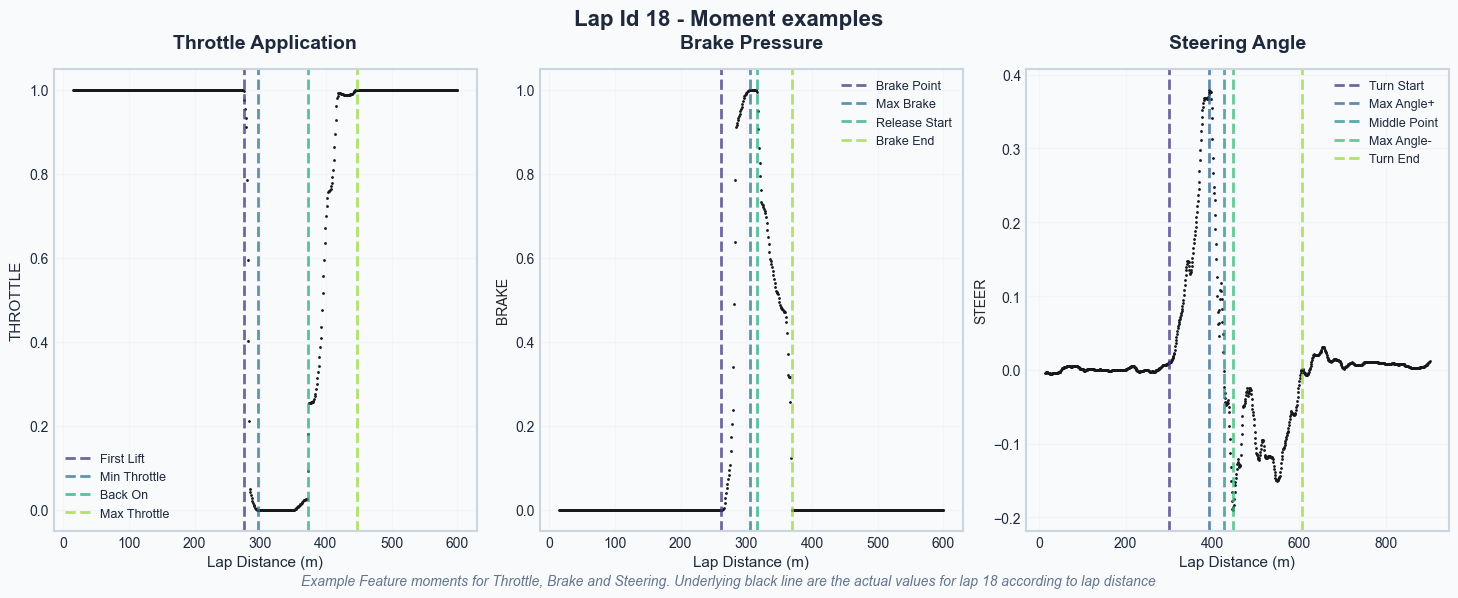

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Set professional light style
plt.style.use('seaborn-v0_8-whitegrid')

# Select one representative lap for the README
# example_lap_id = cleanned_data[cleanned_data["invalid_lap"] == 0].lap_id.sort_values().unique()[343]
example_lap_id = 18

# Create figure with custom styling
fig = plt.figure(figsize=(18, 6), facecolor='#f8fafc')
gs = fig.add_gridspec(1, 3, hspace=0, wspace=0.15)
axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Light theme color scheme
bg_color = '#f8fafc'
grid_color = '#e2e8f0'
throttle_color = '#0891b2'  # Teal
brake_color = '#dc2626'     # Red
steer_color = '#7c3aed'     # Purple
text_color = "#010202"
subtitle_color = '#64748b'
points_color = "#16181b"

# Filter data for the example lap
lap_data = df[df["lap_id"] == example_lap_id]

# Distance ranges
distance_ranges = [(0, 600), (0, 600), (0, 900)]
y_cols = ["THROTTLE", "BRAKE", "STEER"]
titles = ["Throttle Application", "Brake Pressure", "Steering Angle"]

# Feature line definitions
feature_lines = [
    ["first_lift_LD", "min_throttle_LD", "back_on_LD", "back_on_max_LD"],
    ["BP_LD", "max_brake_LD", "brake_decrease_LD", "brake_end_LD"],
    ["first_steer_LD", "max_pos_angle_steer_LD", "middle_TP_LD", "max_neg_LD", "end_steer_LD"]
]

feature_dfs = [thp, bps, sta]

feature_labels = [
    ["First Lift", "Min Throttle", "Back On", "Max Throttle"],
    ["Brake Point", "Max Brake", "Release Start", "Brake End"],
    ["Turn Start", "Max Angle+", "Middle Point", "Max Angle-", "Turn End"]
]

# Plot each telemetry channel
for i, (ax, y_col, d_range, title) in enumerate(zip(axs, y_cols, distance_ranges, titles)):
    ax.set_facecolor(bg_color)
    
    # Plot main data with gradient effect
    plot_laps(lap_data, y_col=y_col, distance_range=d_range, ax=ax, only_valid=False, c = points_color)
    
    # Customize the line appearance
    lines = ax.get_lines()
    if lines:
        line_colors = [throttle_color, brake_color, steer_color]
        lines[0].set_color(line_colors[i])
        lines[0].set_linewidth(2.5)
        lines[0].set_alpha(0.9)
    
    # Add feature markers
    feature_df = feature_dfs[i]
    features = feature_lines[i]
    labels = feature_labels[i]
    
    lap_features = feature_df[feature_df["lap_id"] == example_lap_id]
    
    # Use a color gradient for features (adjusted for light theme)
    n_features = len(features)
    colors = plt.cm.viridis(np.linspace(0.15, 0.85, n_features))
    
    for j, (feature, label) in enumerate(zip(features, labels)):
        if feature in lap_features.columns:
            x_val = lap_features[feature].values[0]
            if not np.isnan(x_val):
                ax.axvline(x_val, color=colors[j], linestyle='--', 
                          linewidth=2, alpha=0.75, label=label)
    
    # Styling
    ax.set_title(title, fontsize=14, fontweight='bold', 
                color=text_color, pad=15)
    ax.set_xlabel('Lap Distance (m)', fontsize=11, color=text_color)
    if i == 0:
        ax.set_ylabel('THROTTLE', fontsize=11, color=text_color)
    
    # Grid
    ax.grid(True, alpha=0.3, color=grid_color, linestyle='-', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Spines
    for spine in ax.spines.values():
        spine.set_color('#cbd5e1')
        spine.set_linewidth(1.5)
    
    # Tick colors
    ax.tick_params(colors=text_color, which='both')
    
    # Add legend with custom styling
    if features:
        legend = ax.legend(loc='best', framealpha=0.95, 
                          facecolor='white', edgecolor='#cbd5e1',
                          fontsize=9)
        plt.setp(legend.get_texts(), color=text_color)

# Add main title
fig.suptitle(f'Lap Id {example_lap_id} - Moment examples', 
            fontsize=16, fontweight='bold', color=text_color, y=0.98)

# Add subtle subtitle
fig.text(0.5, 0.02, f'Example Feature moments for Throttle, Brake and Steering. Underlying black line are the actual values for lap {example_lap_id} according to lap distance', 
         ha='center', fontsize=10, color=subtitle_color, style='italic')

# plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Optional: Save high-quality version for README
fig.savefig('images/telemetry_features.png', dpi=300, facecolor=bg_color, 
            edgecolor='none', bbox_inches='tight')

## Track Width Graph

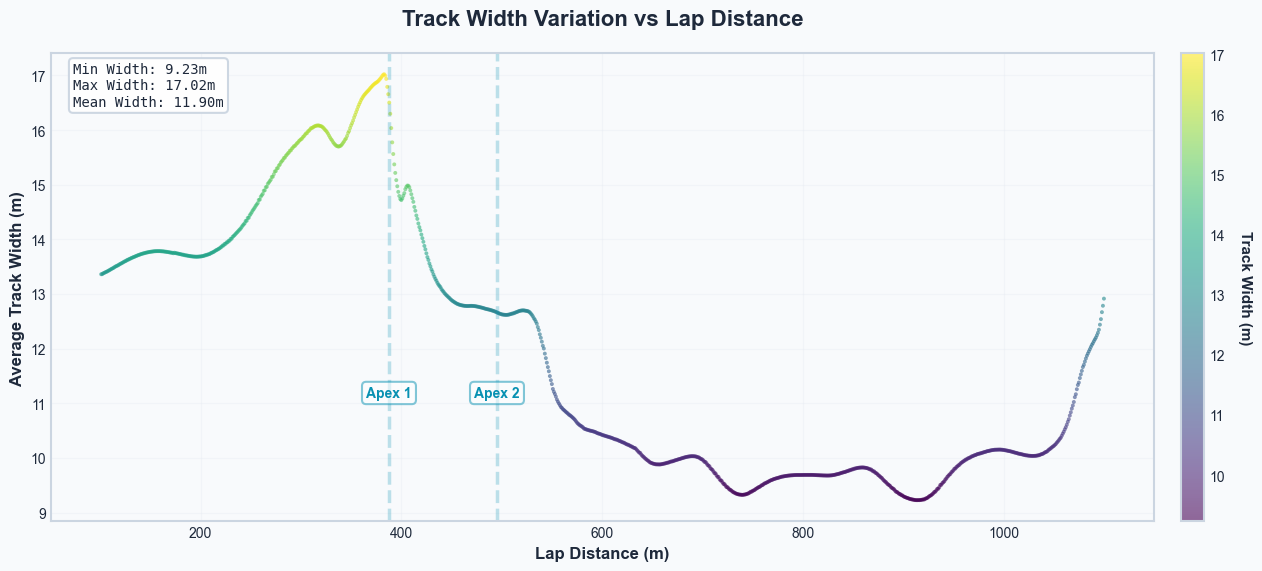

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Set professional light style
plt.style.use('seaborn-v0_8-whitegrid')

# Prepare data
track_width_graph = df[["l_width", "r_width", "LAPDISTANCE"]].groupby("LAPDISTANCE").mean()
trimmed_data = track_width_graph.iloc[100:-100]
lap_distance = trimmed_data.index
avg_width = (trimmed_data["l_width"] + trimmed_data["r_width"]) / 2

# Create figure with professional styling
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#f8fafc')
ax.set_facecolor('#f8fafc')

# Color scheme
primary_color = '#0891b2'  # Teal
fill_color = '#67e8f9'     # Light teal
grid_color = '#e2e8f0'
text_color = '#1e293b'
subtitle_color = '#64748b'

# Plot the track width with enhanced styling
scatter = ax.scatter(lap_distance, avg_width, 
                    c=avg_width, cmap='viridis', 
                    s=8, alpha=0.6, edgecolors='none')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Track Width (m)', rotation=270, labelpad=20, 
              fontsize=11, color=text_color, fontweight='bold')
cbar.ax.tick_params(colors=text_color)
cbar.outline.set_edgecolor('#cbd5e1')
cbar.outline.set_linewidth(1.5)
apex1_distance = 387.7423076923077
apex2_distance = 495.3326923076923

ax.axvline(apex1_distance, color='#0891b2', linestyle='--', 
          linewidth=2.5, alpha=0.25, label='Apex 1')
ax.axvline(apex2_distance, color='#0891b2', linestyle='--', 
          linewidth=2.5, alpha=0.25, label='Apex 2')

# Add apex annotations
ax.text(apex1_distance, ax.get_ylim()[1] * 0.65, 'Apex 1', 
       ha='center', va='top', fontsize=10, color='#0891b2', 
       fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', 
                                    edgecolor='#0891b2', alpha=0.5, linewidth=1.5))
ax.text(apex2_distance, ax.get_ylim()[1] * 0.65, 'Apex 2', 
       ha='center', va='top', fontsize=10, color='#0891b2', 
       fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', 
                                    edgecolor='#0891b2', alpha=0.5, linewidth=1.5))
# Styling
ax.set_title('Track Width Variation vs Lap Distance', 
            fontsize=16, fontweight='bold', color=text_color, pad=20)
ax.set_xlabel('Lap Distance (m)', fontsize=12, color=text_color, fontweight='600')
ax.set_ylabel('Average Track Width (m)', fontsize=12, color=text_color, fontweight='600')

# Grid
ax.grid(True, alpha=0.3, color=grid_color, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)

# Spines
for spine in ax.spines.values():
    spine.set_color('#cbd5e1')
    spine.set_linewidth(1.5)

# Tick styling
ax.tick_params(colors=text_color, which='both', labelsize=10)

# Add statistics text box
stats_text = f"Min Width: {avg_width.min():.2f}m\nMax Width: {avg_width.max():.2f}m\nMean Width: {avg_width.mean():.2f}m"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', 
                edgecolor='#cbd5e1', alpha=0.95, linewidth=1.5),
       color=text_color, fontfamily='monospace')


plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

fig.savefig('images/track_width_analysis.png', dpi=300, facecolor='#f8fafc', 
            edgecolor='none', bbox_inches='tight')

In [126]:
am["APX1_LAPDISTANCE"].mean(), am["APX2_LAPDISTANCE"].mean()


(387.7423076923077, 495.3326923076923)

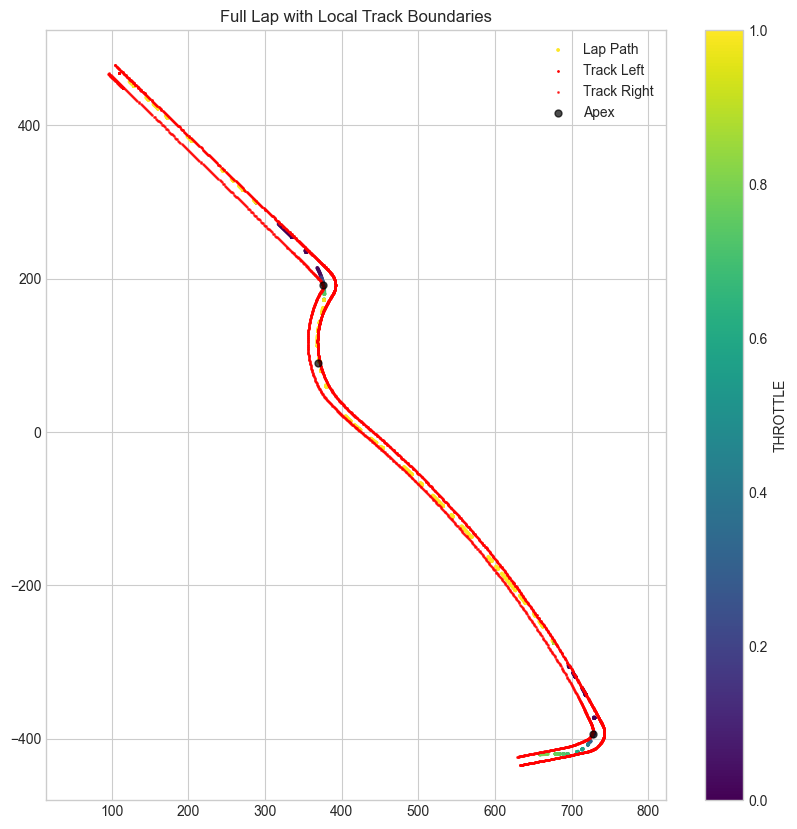

In [69]:
plot_lap(lap_data, track_left, track_right, turns, color_col="THROTTLE")

<Axes: >

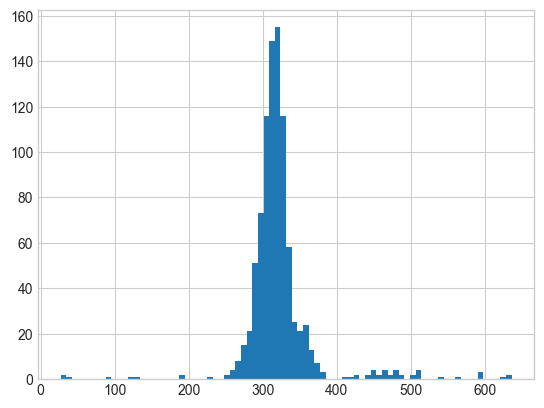

In [45]:
sta["first_steer_LD"].hist(bins=80)

In [46]:
for idx in cleanned_data[cleanned_data["invalid_lap"] == 0].lap_id.sort_values().unique():
    # ax = plt.gca()
    fig, axs = plt.subplots(1,2, sharey=True, figsize=(12*2, 8*1))

    plot_laps(cleanned_data[cleanned_data["lap_id"] == idx], y_col="THROTTLE", distance_range=(0, 600), ax=axs[0], only_valid=False)
    plot_laps(cleanned_data[cleanned_data["lap_id"] == idx], y_col="BRAKE", distance_range=(0, 600), ax=axs[1], only_valid=False)
    axs[0].set_title(f"Lap_id {idx} BRAKE vs LAPDISTANCE")

    for line in ["first_lift_LD", "min_throttle_LD", "back_on_LD", "back_on_max_LD"]:

        axs[0].vlines(thp[thp["lap_id"] == idx][line], 0, 1, colors="red")
        # axs[0].vlines(thp[thp["lap_id"] == idx]["min_throttle_LD"], 0, 1, colors="red")
    
    for line in ["BP_LD", "max_brake_LD", "brake_decrease_LD", "brake_end_LD"]:
        axs[1].vlines(bps[bps["lap_id"] == idx][line], 0, 1)
    plt.show()

NameError: name 'cleanned_data' is not defined

In [96]:
final_dist_df = cleanned_data[cleanned_data["invalid_lap"] == 0][["lap_id"]].drop_duplicates().set_index("lap_id").sort_index().copy()
final_dist_df.loc[:, "dist"] = 900
target_df = moment_generator(cleanned_data, "Target", ["CURRENTLAPTIMEINMS"], final_dist_df["dist"])

In [44]:
target_df

Target_CURRENTLAPTIMEINMS
lap_id                           
0                           26183
1                           15406
2                           25208
3                           14677
4                           16324
...                           ...
1046                        12470
1047                        21850
1048                        21674
1049                        17139
1050                        29955

[1040 rows x 1 columns]

<Axes: >

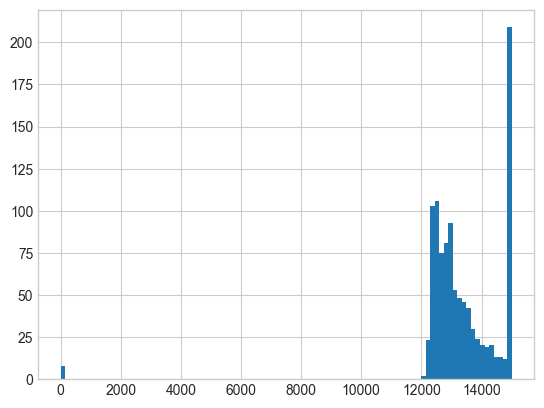

In [43]:
target_df["Target_CURRENTLAPTIMEINMS"].clip(0, 15000).hist(bins = 100)

In [42]:
target_df["Target_CURRENTLAPTIMEINMS"].argmin()

14

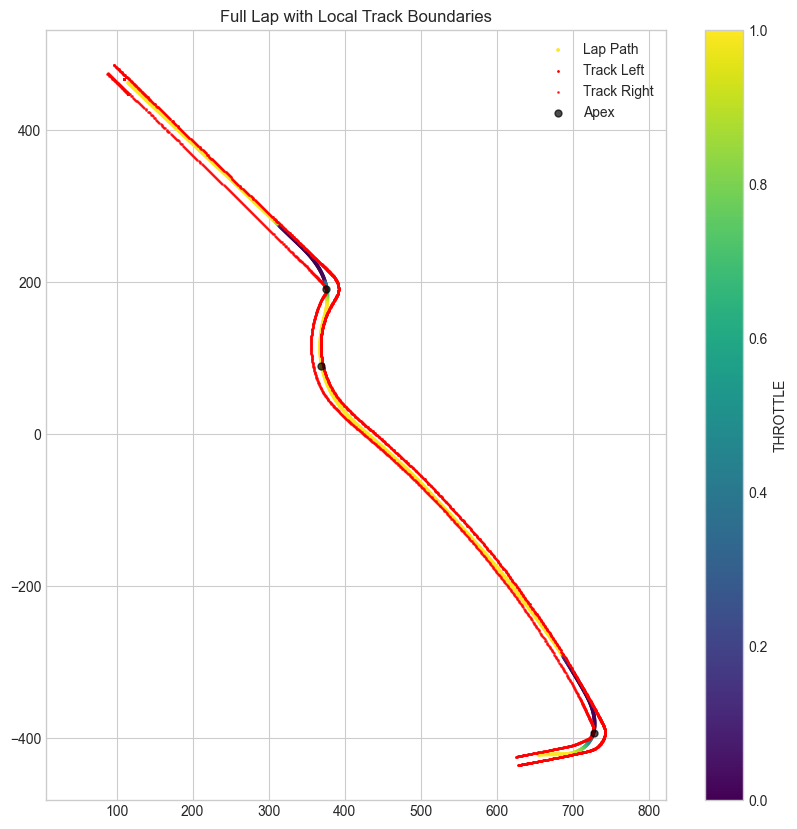

In [41]:
plot_lap(df[df["lap_id"] == 860], track_left, track_right, turns, color_col="THROTTLE")